In [1]:
# This is distributed under BSD 3-Clause license

import torch
import numpy
import os
import errno

from torch import optim
from torch import legacy
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


from six.moves import urllib

#loss_plot = []

def tensor_from_file(root, filename,
                     base_url = 'https://documents.epfl.ch/users/f/fl/fleuret/www/data/bci'):

    file_path = os.path.join(root, filename)

    if not os.path.exists(file_path):
        try:
            os.makedirs(root)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        url = base_url + '/' + filename

        print('Downloading ' + url)
        data = urllib.request.urlopen(url)
        with open(file_path, 'wb') as f:
            f.write(data.read())

    return torch.from_numpy(numpy.loadtxt(file_path))

def load(root, train = True, download = True, one_khz = False):
    """
    Args:

        root (string): Root directory of dataset.

        train (bool, optional): If True, creates dataset from training data.

        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

        one_khz (bool, optional): If True, creates dataset from the 1000Hz data instead
            of the default 100Hz.

    """

    nb_electrodes = 28

    if train:

        if one_khz:
            dataset = tensor_from_file(root, 'sp1s_aa_train_1000Hz.txt')
        else:
            dataset = tensor_from_file(root, 'sp1s_aa_train.txt')

        input = dataset.narrow(1, 1, dataset.size(1) - 1)
        input = input.float().view(input.size(0), nb_electrodes, -1)
        target = dataset.narrow(1, 0, 1).clone().view(-1).long() #changer le type suivant le loss criterion

    else:

        if one_khz:
            input = tensor_from_file(root, 'sp1s_aa_test_1000Hz.txt')
        else:
            input = tensor_from_file(root, 'sp1s_aa_test.txt')
        target = tensor_from_file(root, 'labels_data_set_iv.txt')

        input = input.float().view(input.size(0), nb_electrodes, -1)
        target = target.view(-1).long() #changer le type suivant le loss criterion

    return input, target
            
#################################################################

def compute_nb_errors(model, data_input, data_target, mini_batch_size):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(0, mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors
            

# Loading data, Increase the Dataset and Create Validation Set


torch.Size([450, 28, 50])
torch.Size([450, 28, 50])


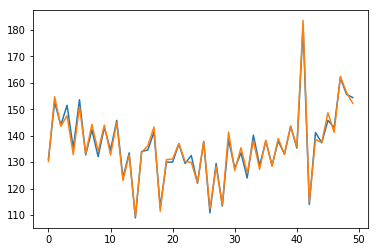

In [4]:
train_input, train_target = load("data",True, False)
test_input, test_target = load("data",False, False)
train_input, train_target, test_input, test_target = \
Variable(train_input.narrow(0, 0,300)), Variable(train_target.narrow(0,0,300)), Variable(test_input), Variable(test_target)

def valSet(train_input,percentageVal):
    
    permutation = torch.randperm(train_input.size()[0])
    sizeVal=round(percentageVal/100*train_input.size()[0])
    
    validation_set=train_input[permutation].narrow(0,0,sizeVal)
    new_train_input=train_input[permutation].narrow(0,sizeVal,train_input.size()[0]-sizeVal)
    
    return new_train_input, validation_set


#adding white noise to the signal
dataNoisy=Variable(torch.Tensor(train_input.size()))
for i in range(0,train_input.size(0)):
    for j in range(0,train_input.size(1)):
        noise = numpy.random.normal(0,2,50) #vector of 50 values with normal distribution of mean=0, std=2
        noiseVar=Variable(torch.Tensor(noise))
        dataNoisy[i,j,:]=train_input[i,j,:].add(noiseVar)



#adding white noise to the signal
dataNoisy2=Variable(torch.Tensor(train_input.size()))
for i in range(0,train_input.size(0)):
    for j in range(0,train_input.size(1)):
        noise = numpy.random.normal(0,4,50) #vector of 50 values with normal distribution of mean=0, std=2
        noiseVar=Variable(torch.Tensor(noise))
        dataNoisy2[i,j,:]=train_input[i,j,:].add(noiseVar)




#verification
plt.plot(train_input[30,10,:].data.numpy())
plt.plot(dataNoisy[30,10,:].data.numpy())
train_input.size(1)

train_input = torch.cat((train_input, dataNoisy), 0) #the two matrices are concatenated
train_input = torch.cat((train_input, dataNoisy2), 0)

train_target=torch.cat((train_target, train_target), 0)
train_target=torch.cat((train_target, train_target), 0)
#new_train_input.size()



train_input, validation_set = valSet(train_input,50)
print(train_input.size())
print(validation_set.size())

# Train Model function

In [148]:
def train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size):
    lr = 1e-3
    step_size = 20
    
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr = lr)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    #Optimizer to update the Learning rate
    scheduler = 0
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, threshold=1, factor=0.5, patience = 30 )
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma=0.1, last_epoch=-1)
   
    
    for e in range(0, nb_epochs):
        permutation = torch.randperm(train_input.size()[0])
        sum_loss = 0
        for b in range(0, train_input.size(0), batch_size):
            indices = permutation[b:b+batch_size]
            batch_input, batch_target = train_input[indices], train_target[indices]
            
            output = model(batch_input)
            loss = criterion(output, batch_target)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss
            
        #print("The loss is :"+str(loss)+" for epoch :"+str(e))
        loss_plot.append(sum_loss.data.numpy())
        print(str(int((e/nb_epochs)*100))+"%")
        if sum_loss.data.numpy()< 0.01:
            break
        if scheduler != 0:
            #scheduler.step(sum_loss.data.numpy())
            scheduler.step()
            
    return e

# Network Model

In [149]:
#################################################################
class NetLin(nn.Module):
    def __init__(self, nb_hidden):
        super(NetLin, self).__init__()
        self.fc1 = nn.Linear(28*50,2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

####################################################################################################################


class Netbasic(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=2)
        self.fc1 = nn.Linear(128*3, nb_hidden*3)
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden*2)
        self.fc3 = nn.Linear(nb_hidden*2, nb_hidden)
        self.fc4 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #x = self.dropout(x)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#model = nn.Sequential(
    #nn.Conv1d(28, 32, kernel_size=5), 
    #nn.ReLU(),
    #nn.Conv1d(56, 56, kernel_size=4, stride = 2),
    #nn.ReLU(),
    #nn.MaxPool1d(kernel_size = 5, stride = 3),
    #nn.ReLU(),
    #nn.Conv1d(56,56, kernel_size = 4, stride = 1),
    #nn.ReLU(),
    #nn.Linear(32*46,79),
    #nn.ReLU(),
    #nn.Linear(79, 2))




In [150]:
#method seen on https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(1,6))
        self.conv2 =  nn.Conv2d(28, 1, kernel_size=(1,1))
        self.conv3 = nn.Conv1d(20, 40, kernel_size=10)
        self.conv4 = nn.Conv1d(40, 80, kernel_size=4)
        self.conv5 = nn.Conv1d(80, 160, kernel_size=4)
        
        
        self.fc1 = nn.Linear(160*2, nb_hidden*3)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #Nx28*50
        #print(x.size())
        x=x.unsqueeze(1) #Nx1x28x50
        #print(x.size())
        x=F.elu(self.conv1(x),alpha=4.0, inplace = True ) #Nx20x28x45
        #print(x.size())
        x=x.transpose(1,2) #Nx28x20x45
        #print(x.size())
        x=F.elu(self.conv2(x)) #Nx1x20x45
        #print("efwef"+str(x.size()))
        
        
        x=x.squeeze() #Nx20x45
        #print(x.size())
        #time.sleep(10)
        x = F.relu(F.max_pool1d(x,4,stride = 1)) #Nx20x42
        
        
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=4,stride = 1 )) #Nx40x33 -> Nx40x30
        
        
        x = F.relu(F.max_pool1d(self.conv4(x), kernel_size=3,stride = 3 )) #Nx80x27 -> Nx80x9
        
        
        x = F.relu(F.max_pool1d(self.conv5(x), kernel_size=3,stride = 3 )) #Nx160x6 -> Nx160x2   
        
        
        
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [151]:
class NetSWAG(nn.Module):
    def __init__(self, nb_hidden):
        super(NetSWAG, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        #self.conv3 = nn.Conv1d(32, 32, kernel_size=3)
        self.fc1 = nn.Linear(128*11, nb_hidden)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [152]:
class NetDROP(nn.Module):
    def __init__(self, nb_hidden):
        super(NetDROP, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=4)
        self.fc1 = nn.Linear(256*4, 3*nb_hidden)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x=self.dropout(x)
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x=self.dropout(x)
        x = F.relu(self.fc2(x))
        x=self.dropout(x)
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [153]:
class NetGIT(nn.Module):
    def __init__(self, nb_hidden):
        super(NetGIT, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=2)
        self.fc1 = nn.Linear(128*3, nb_hidden*3)
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden*2)
        self.fc3 = nn.Linear(nb_hidden*2, nb_hidden)
        self.fc4 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #x = self.dropout(x)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [154]:
class NetOLDANDDUMB(nn.Module):
    def __init__(self, nb_hidden):
        super(NetOLDANDDUMB, self).__init__()
        self.conv1 = nn.Conv1d(28, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3)
        #self.conv3 = nn.Conv1d(32, 32, kernel_size=3)
        self.fc1 = nn.Linear(32*11, nb_hidden)
        
        #self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        #self.dropout = nn.Dropout()
        

    def forward(self, x):
        nn.Dropout(p = 0.7)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        nn.Dropout(p = 0.7)
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [167]:
class NetOLDANDDUMB2(nn.Module):
    def __init__(self, nb_hidden):
        super(NetOLDANDDUMB2, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3)
        #self.conv3 = nn.Conv1d(32, 32, kernel_size=3)
        self.fc1 = nn.Linear(64*11, nb_hidden)
        
        self.fc2 = nn.Linear(nb_hidden, 30)
        self.fc3 = nn.Linear(30, 2)
        #self.dropout = nn.Dropout()
        

    def forward(self, x):
        nn.Dropout(p = 0.7)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        nn.Dropout(p = 0.7)
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

# Loading the right model

In [168]:
model = NetOLDANDDUMB2(150)

# Testing function

0%
0%
1%
1%
2%
2%
3%
3%
4%
4%
5%
5%
6%
6%
7%
7%
8%
8%
9%
9%
10%
10%
11%
11%
12%
12%
13%
13%
14%
14%
15%
15%
16%
16%
17%
17%
18%
18%
19%
19%
 train_error 0.00% test_error 27.00%


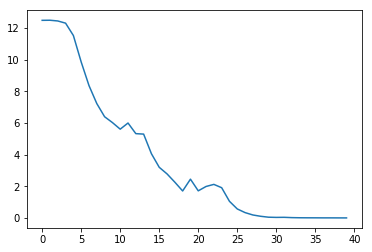

0%
0%
1%
1%
2%
2%
3%
3%
4%
4%
5%
5%
6%
6%
7%
7%
8%
8%
9%
9%
10%
10%
11%
11%
12%
12%
13%
13%
14%
14%
15%
15%
16%
16%
17%
17%
18%
18%
19%
19%
20%
20%
21%
21%
22%
22%
23%
 train_error 0.00% test_error 31.00%


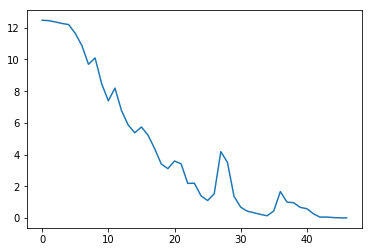

0%
0%
1%
1%
2%
2%
3%
3%
4%
4%
5%
5%
6%
6%
7%
7%
8%
8%
9%
9%
10%
10%
11%
11%
12%
12%
13%
13%
14%
14%
15%
15%
16%
16%
17%
17%
18%
 train_error 0.00% test_error 25.00%


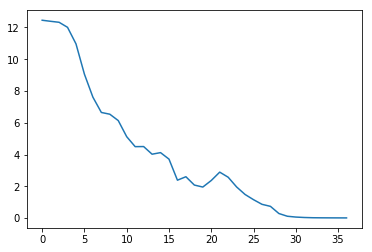

In [169]:
# test multiple prior init
nb_epochs =  200
batch_size = 50


nb_training = 3

for i in range(0,nb_training):
    for p in model.parameters(): p.data.normal_(0, 0.01)
    loss_plot = []
    epochs_reached = train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size = batch_size)
    
    
    
    print(' train_error {:.02f}% test_error {:.02f}%'.format(
                compute_nb_errors(model, train_input, train_target, 20) / train_input.size(0) * 100,
                compute_nb_errors(model, test_input, test_target, 50) / test_input.size(0) * 100))
    #loss_plot
    for p in model.parameters(): p.data.normal_(0, 0.01)
    plt.plot(range(epochs_reached+1),loss_plot)
    plt.show()
    